In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Add function path
original_path = os.getcwd()
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)

# Import custom functions
from analysis_function import *
from kcc_constrain_function import *
from Plot_function import *
from f1_0_H_sum_multi_region_constrain import *
from f_IMP import *
from f_schemes import *
from p_IMP_plot import *
import regionmask

In [8]:
# Your custom order
groups = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN']
}

# Flatten region list in desired order
ordered_regions = [abbr for group in groups.values() for abbr in group]
ordered_groups = [group for group, regions in groups.items() for _ in regions]


In [10]:
def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

path = './saved_data/'
name = '1.0_IPM_Prior_posterier_Pseudo_warming_period_2016-2025_ref1850-1900.pkl'

prior_post_all = load_xr_pickle(path + name)


prior = prior_post_all["prior_all_schemes"]
post = prior_post_all["post_all_schemes"]
pseudo = prior_post_all["pseudo_warming"].sel(region=ordered_regions)

prior_post_7scheme = xr.concat([post, prior.mean('scheme').expand_dims(scheme = ['prior'])], dim = 'scheme').squeeze().sel(region=ordered_regions)

prior_post_group = group_by_model_name(prior_post_7scheme, dim_name = 'model_name')

pseudo_group = group_by_model_name(pseudo, dim_name = 'model_name')
pseudo_group

[<xarray.DataArray 'pseudo_warming' (pseudo: 3, region: 46)> Size: 1kB
 array([[1.91725293, 2.15758632, 2.50221462, 1.61862192, 1.51360023,
         1.4319857 , 1.53111865, 1.09215408, 1.08713755, 1.43014787,
         1.80366189, 1.4499103 , 1.68692191, 1.1163757 , 1.34429588,
         0.85834713, 1.62986006, 1.76890342, 2.39276798, 1.51871182,
         2.04524934, 1.47651238, 1.71151123, 1.51012157, 1.58071883,
         1.49306207, 1.40391267, 1.22872094, 3.08444389, 2.2562567 ,
         2.03988368, 2.23113217, 1.6875752 , 1.66575338, 1.37217414,
         1.32070251, 2.00681513, 1.24206194, 1.18060166, 1.3493838 ,
         1.57995645, 1.51860092, 1.08174775, 1.22312152, 1.43937397,
         1.21475107],
        [2.34194702, 1.85461805, 2.58254535, 1.72219879, 1.62529404,
         1.4199869 , 1.48007219, 1.09261964, 1.06958667, 1.38066222,
         1.62199018, 1.32688636, 1.5202015 , 1.03239884, 0.92090508,
         0.86396379, 1.95936863, 1.97085358, 1.43189981, 1.76831942,
         2

In [11]:
scale_factor = 1.31

prior_post_7scheme_adj = scale_gaussian_percentiles(prior_post_7scheme, scale_factor=scale_factor)
prior_post_group_adj = group_by_model_name(prior_post_7scheme_adj, dim_name = 'model_name')
prior_post_group_adj

[<xarray.DataArray 'post_all_schemes' (scheme: 7, pseudo: 3, region: 46,
                                       quantile: 3)> Size: 23kB
 array([[[[2.25541046, 0.00933588, 4.50148505],
          [2.11989228, 1.10678285, 3.13300171],
          [2.71020652, 1.1830976 , 4.23731544],
          ...,
          [1.123903  , 0.91929201, 1.32851399],
          [1.3331155 , 0.52987963, 2.13635136],
          [1.46730665, 0.17820597, 2.75640732]],
 
         [[2.25541046, 0.00933588, 4.50148505],
          [2.28077082, 1.26766139, 3.29388025],
          [2.71020652, 1.1830976 , 4.23731544],
          ...,
          [1.17363853, 0.96902754, 1.37824952],
          [1.3331155 , 0.52987963, 2.13635136],
          [1.46730665, 0.17820597, 2.75640732]],
 
         [[2.25541046, 0.00933588, 4.50148505],
          [2.60152206, 1.58841263, 3.61463149],
          [2.71020652, 1.1830976 , 4.23731544],
          ...,
 ...
          ...,
          [0.93120945, 0.44393671, 1.41848218],
          [1.3331155 , 0

In [12]:
#### Import obs, to count the years on each region
obs_all = load_xr_pickle(path + '0.1.HadCRUT5.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

obs_ar6_yr_count = obs_all.notnull().sum(dim="year")[0:46]

### Calculation

#### RMSE

In [13]:
path = './saved_data/'
mod_45_pseudo = load_xr_pickle(path + '0.5.pseudo-model.15mod.run1-3.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_176years_1850-2025.pkl')

mod_45_pseudo = change_ref(mod_45_pseudo, 1850, 1900).sel(year = slice(2016, 2025)).mean('year').isel(region = slice(0, 46))

mod_45_pseudo = mod_45_pseudo.assign_coords(
    region = ("region", mod_45_pseudo["abbrevs"].values)
)


In [14]:
pseudo_mean_smoothed = mod_45_pseudo.groupby('model_name').mean()
prior_post_group = prior_post_group

n_scheme = len(prior_post_group[0]['scheme'])
sq_errors_all = []
# for pseudo_id in range(len(pseudo_mean_smoothed)):
for pseudo_id in range(len(pseudo_mean_smoothed)):

    # reference pseudo mean
    pseudo_ref = pseudo_mean_smoothed[pseudo_id]
    post_mean = (
        prior_post_group[pseudo_id]
        .isel(scheme=slice(0, n_scheme))
        .sel(quantile='mean')
    )


    sq_errors = (post_mean - pseudo_ref)**2
    magnitude = pseudo_mean_smoothed[pseudo_id]
    scaled_sq_errors = sq_errors / (magnitude**2)

    # print(sq_errors)
    sq_errors_all.append(scaled_sq_errors)


sq_errors_all = xr.concat(sq_errors_all, dim = 'pseudo')
scaled_rmse_all = np.sqrt(sq_errors_all.sum(dim = 'pseudo')/ len(pseudo_ref))

scaled_rmse_all

confidence_all = 1/(scaled_rmse_all)


#### Uncertainty width


In [15]:
# pseudo
width = prior_post_7scheme.sel(quantile = '95th') - prior_post_7scheme.sel(quantile = '5th')

# pseudo
width_adj = prior_post_7scheme_adj.sel(quantile = '95th') - prior_post_7scheme_adj.sel(quantile = '5th')

width_grouped = width_adj.groupby("model_name")
scaled_width = width_grouped / pseudo_mean_smoothed


#### Coverage rate

In [16]:
### With group coverage

def cal_coverage_rate(pseudo_all_group, prior_post_group, pseudo_id):

    pseudo_true = pseudo_all_group[pseudo_id]
    pseudo_true_mean = pseudo_true.mean('pseudo')

    # prior_all_results[pseudo_id]
    lower_bound = prior_post_group[pseudo_id].squeeze().sel(quantile = '5th')
    upper_bound = prior_post_group[pseudo_id].squeeze().sel(quantile = '95th')

    post_prior_rate = np.logical_and(
                pseudo_true_mean >= lower_bound,
                pseudo_true_mean <= upper_bound
            ).sum('pseudo') / len(pseudo_true['pseudo'])

    post_prior_rate = post_prior_rate.expand_dims(dim = 'pseudo_id').assign_coords(pseudo_id = [prior_post_group[pseudo_id]['model_name'][0].values])

    return(post_prior_rate)

post_prior = []
post_prior_adj = []

for pseudo_id in range(len(prior_post_group)):
    post_prior_rate = cal_coverage_rate(pseudo_group, prior_post_group, pseudo_id)
    post_prior.append(post_prior_rate)


    post_prior_rate = cal_coverage_rate(pseudo_group, prior_post_group_adj, pseudo_id)
    post_prior_adj.append(post_prior_rate)


prior_post_rate = xr.concat(post_prior, dim = 'pseudo_id') * 100

prior_post_rate_adj = xr.concat(post_prior_adj, dim = 'pseudo_id') * 100


### Plot

#### Fig. 4

In [17]:
# data = prior_post_rmse_p1.mean('pseudo_id')

from matplotlib.colors import ListedColormap

def modify_cmap(name='YlGn', start=0.1, end=0.9, gamma=0.8, white_strength=0.3):
    """
    white_strength = 0 → no whitening
    white_strength = 1 → pure white at start
    """
    base = cm.get_cmap(name)
    colors = base(np.linspace(start, end, 256))[:, :3] ** gamma
    
    # Blend first colors toward white
    white = np.array([1, 1, 1])
    for i in range(len(colors)):
        blend_factor = (1 - i / (len(colors)-1)) * white_strength
        colors[i] = (1-blend_factor)*colors[i] + blend_factor*white
    
    return ListedColormap(colors)

# Example
cmap = modify_cmap('YlGn', start=0.0, end=0.95, gamma=1.0, white_strength=1.0)

colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[0:230]
cmap_rmse = colors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)

cmap_width = modify_cmap('Blues', start=0.0, end=1.0, gamma=1.0, white_strength=1)


# Fixed vmin/vmax
vmin, vmax = 70, 100

# Normalize helper
def norm_point(x):
    return (x - vmin) / (vmax - vmin)

# Define colormap control points
cmap_colors = [
    (norm_point(70),   "#9b2226"),  # dark red at 0.7
    (norm_point(85), "white"),    # white starts at 0.875
    (norm_point(95), "white"),    # white ends at 0.925
    (norm_point(100),   "#004b23"),  # dark green at 1.0
]

# Build custom cmap
cmap_coverage = LinearSegmentedColormap.from_list("cmap_coverage", cmap_colors)



/var/folders/jt/kr53pz_j4x3d_32xbfb7pkd87_b0mf/T/ipykernel_55711/2943199660.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)


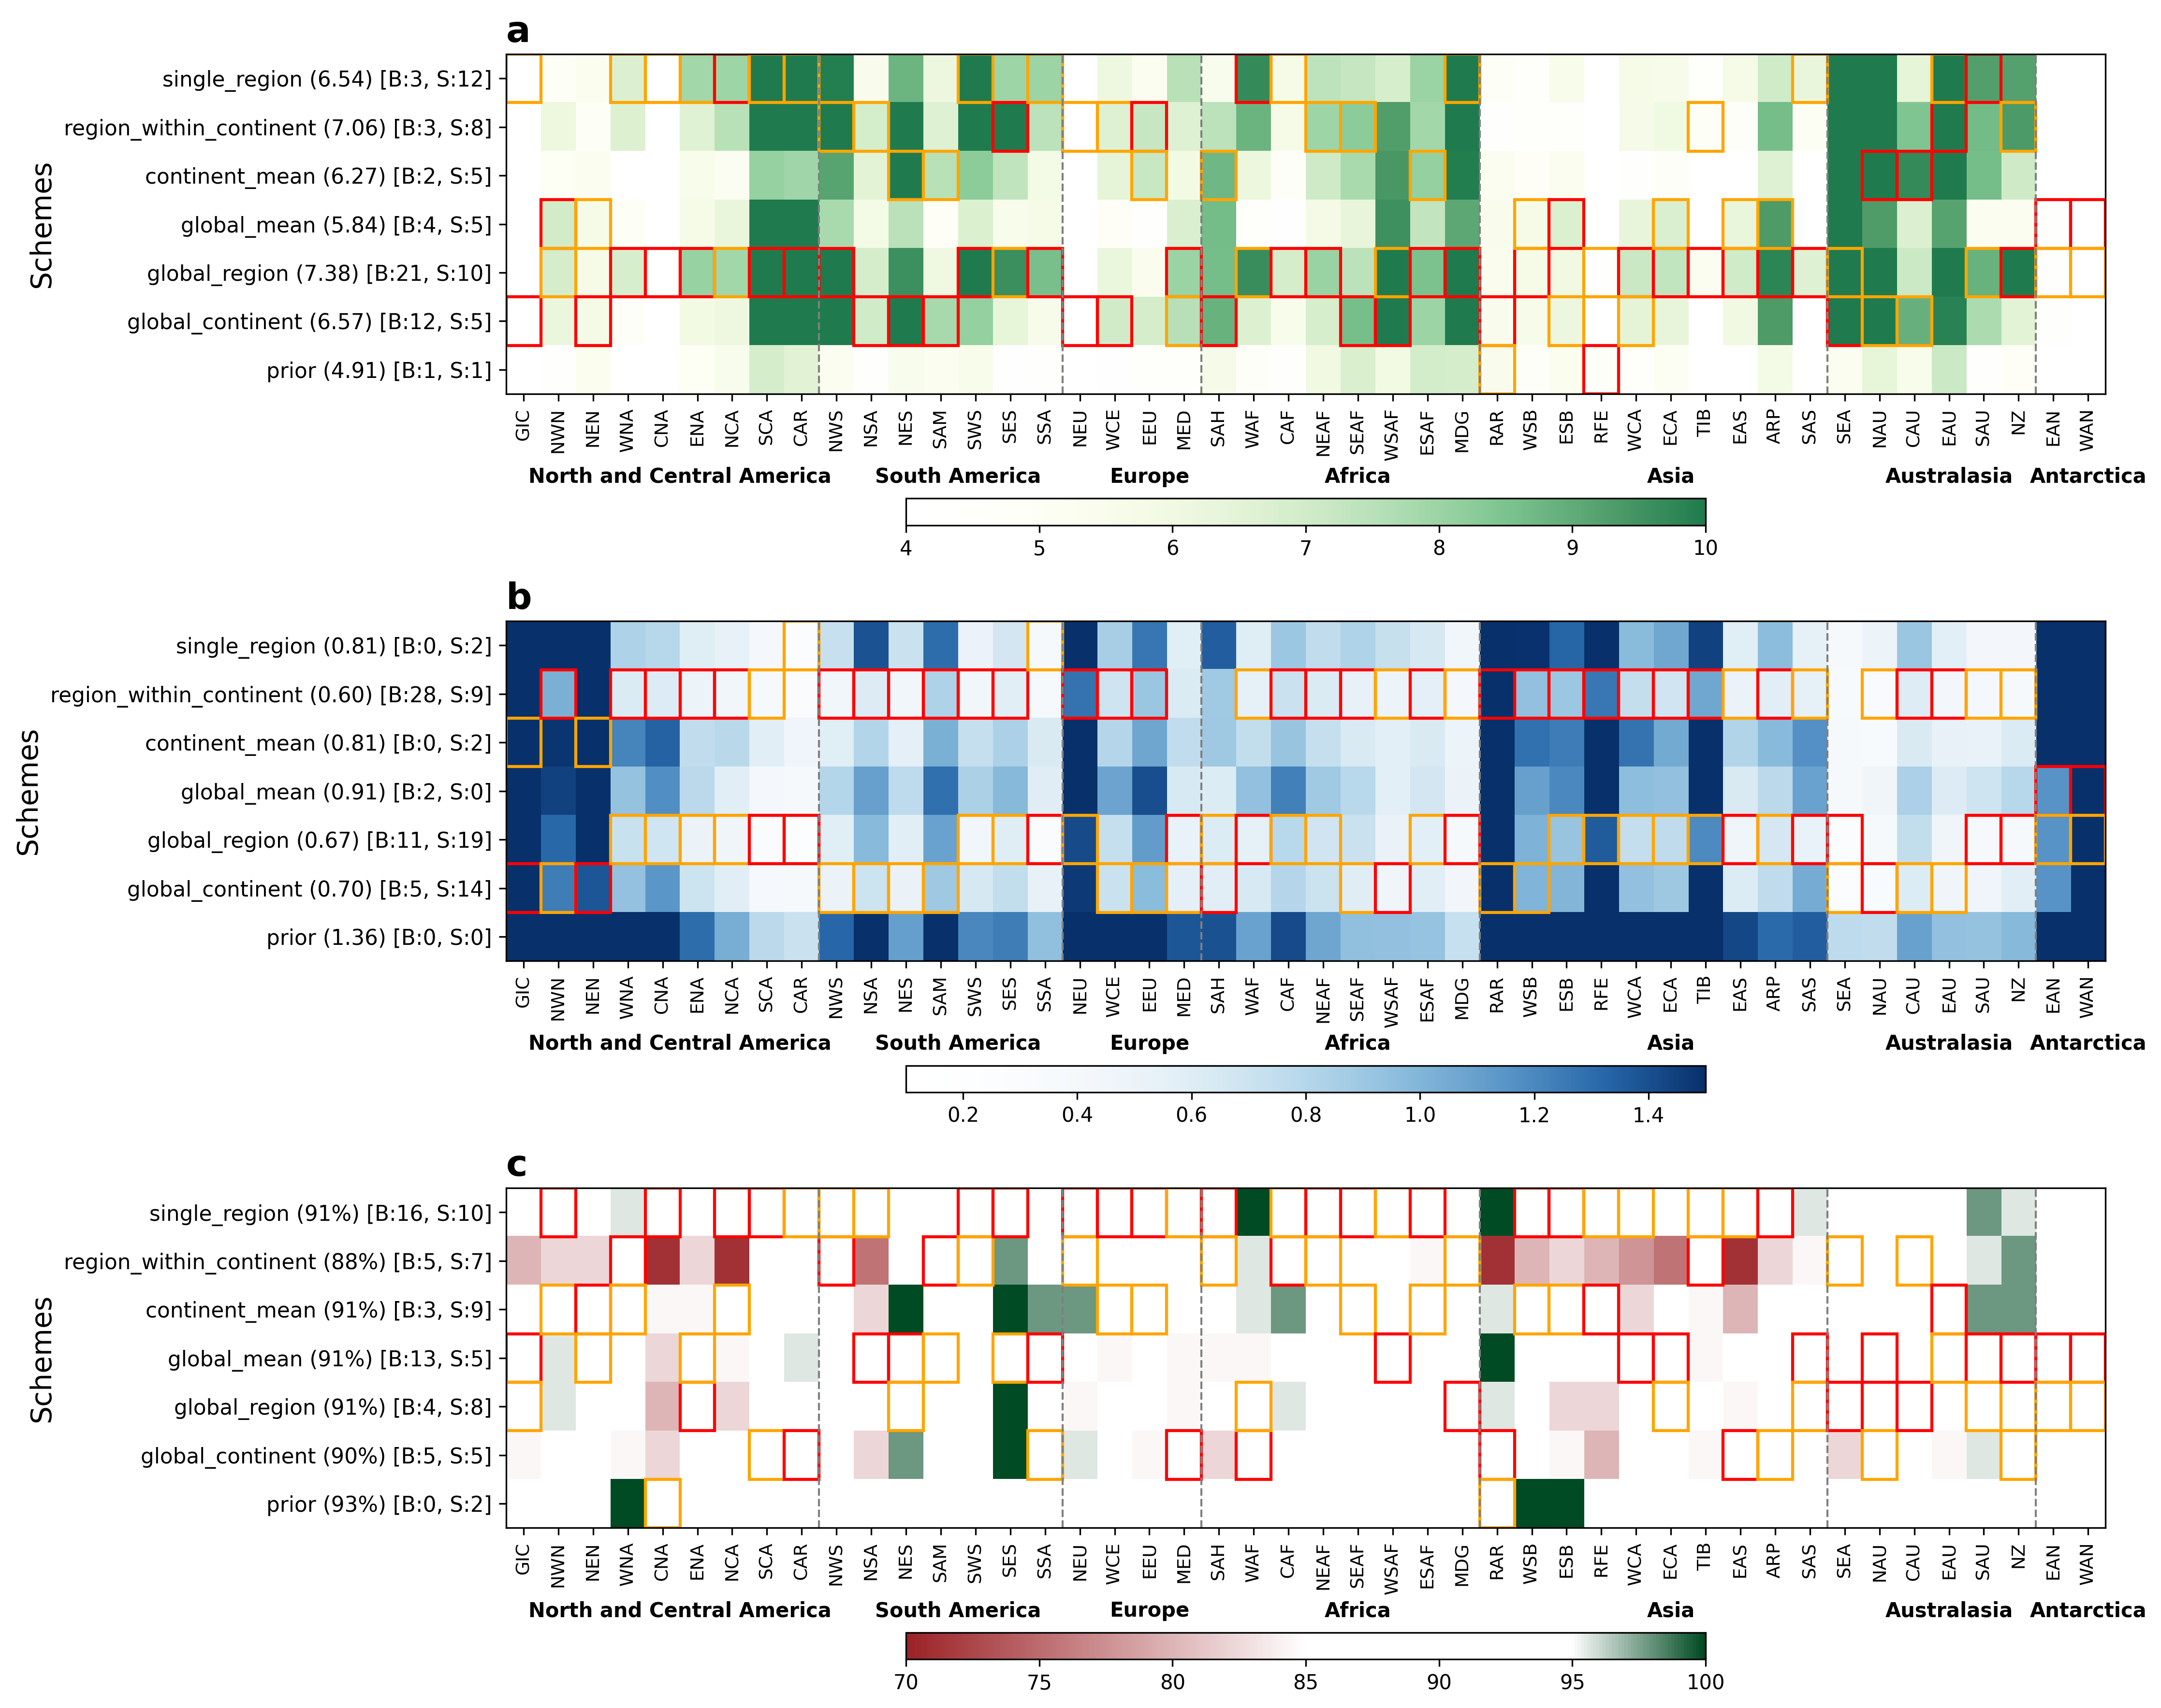

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12), dpi = 300)

# ------------------------
# Panel 1: RMSE / magnitude
# ------------------------
ax = axes[0]
# title = 'RMSE / magnitude'

data = confidence_all.isel(scheme=slice(0, 7))
plot_IMP_heatmap(
    data, groups, cmap_rmse, 'a',
    fig, ax,
    labels_height=8, target=100,
    vmin=4.0, vmax=10
)

# ------------------------
# Panel 2: Uncertainty width
# ------------------------
ax = axes[1]
# title = 'Uncertainty width (after adjustment)'
data = width_adj.mean('pseudo').isel(scheme=slice(0, 7))
plot_IMP_heatmap(
    data, groups, cmap_width, 'b',
    fig, ax,
    labels_height=8, target=0,
    vmin=0.1, vmax=1.5
)

# ------------------------
# Panel 3: Coverage rate
# ------------------------
ax = axes[2]
# title = 'Coverage rate (after adjustment)'
data = prior_post_rate_adj.mean('pseudo_id').isel(scheme=slice(0, 7)).T
plot_IMP_heatmap(
    data, groups, cmap_coverage, 'c',
    fig, ax,
    labels_height=8, target=90,
    vmin=70, vmax=100,
    decimal=0,
    coverage_rate=True
)

plt.tight_layout()
plt.show()

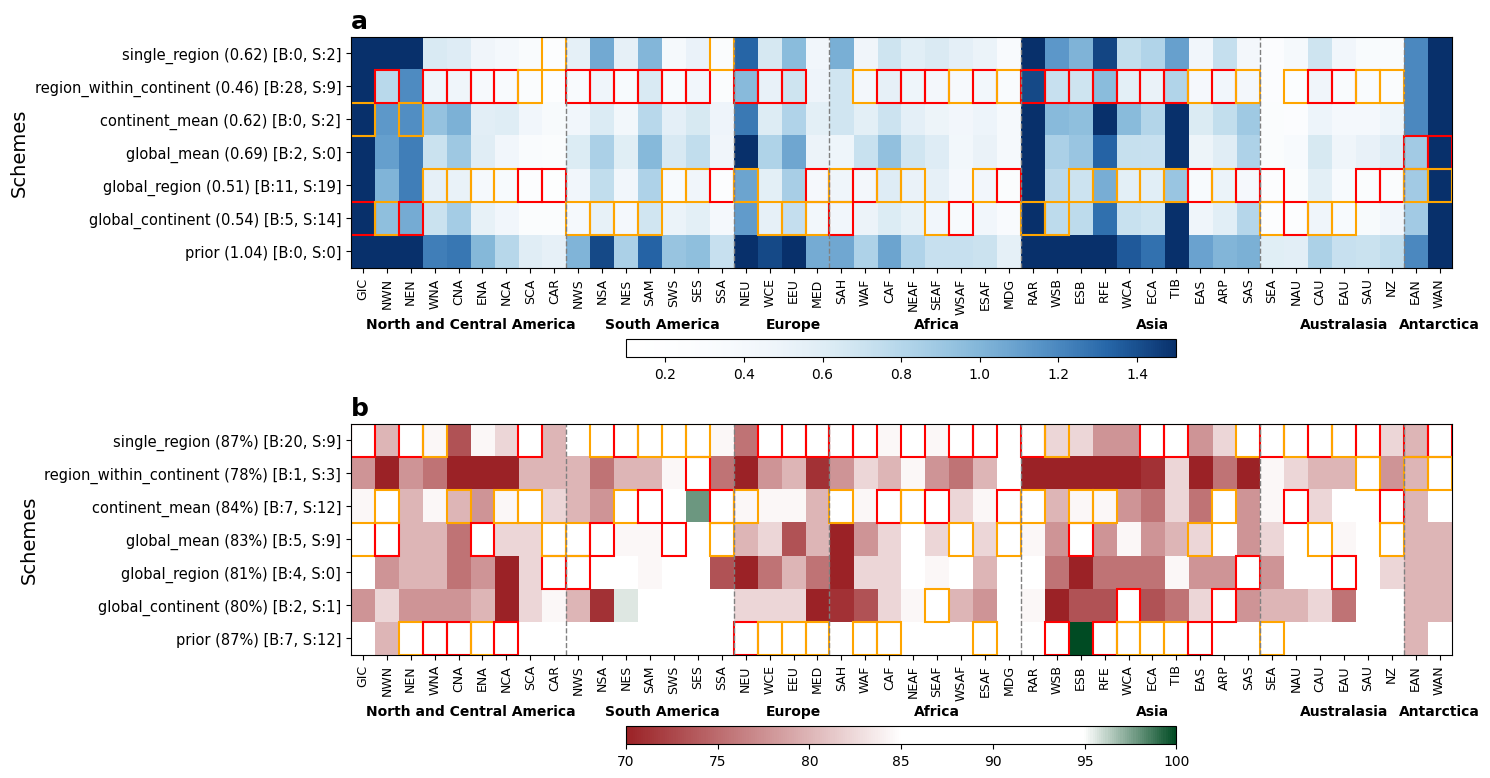

In [19]:
### Before adjustment
fig, axes = plt.subplots(2, 1, figsize=(15, 8))


# ------------------------
# ------------------------
# Panel 1: Uncertainty width
# ------------------------
ax = axes[0]
# title = 'Uncertainty width (after adjustment)'
data = width.mean('pseudo').isel(scheme=slice(0, 7))
plot_IMP_heatmap(
    data, groups, cmap_width, 'a',
    fig, ax,
    labels_height=8, target=0,
    vmin=0.1, vmax=1.5
)

# ------------------------
# Panel 2: Coverage rate
# ------------------------
ax = axes[1]
# title = 'Coverage rate (after adjustment)'
data = prior_post_rate.mean('pseudo_id').isel(scheme=slice(0, 7)).T
plot_IMP_heatmap(
    data, groups, cmap_coverage, 'b',
    fig, ax,
    labels_height=8, target=90,
    vmin=70, vmax=100,
    decimal=0,
    coverage_rate=True
)

plt.tight_layout()
plt.show()